In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy
from keras import backend as K

np.random.seed(666);

/home/szarki/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Data preprocessing

In [2]:
train = pd.read_json('cooking_train.json')
print ('recipes: ', train.shape[0])
print ('cuisines', sorted(set(train.cuisine)))

recipes:  30000
cuisines ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']


In [3]:
ingredients = [i for sublist in train.ingredients for i in sublist]
ingredients = sorted(set(ingredients))

ingredients_size = len(ingredients)

In [4]:
cuisine = sorted(set(train.cuisine))
cuisine_size = len(cuisine)

print(ingredients_size)
print(cuisine_size)

6251
20


In [5]:
def preprocessor(line):
    return ' '.join(line).lower()

In [6]:
X_raw = train.ingredients
Y_raw = train.cuisine

In [7]:
vect_in = CountVectorizer(preprocessor=preprocessor)
X_train = vect_in.fit_transform(X_raw).todense()
print(X_train)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [8]:
lab_enc = LabelEncoder()
Y_train = lab_enc.fit_transform(Y_raw)
Y_train = to_categorical(Y_train, num_classes=20)

In [9]:
input_dim = X_train.shape[1]
print(input_dim)
print(Y_train.shape)

2866
(30000, 20)


In [10]:
print(X_train)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [11]:
print(Y_train.shape)

(30000, 20)


## Neural Network

NN might work well, because different ingredients might have various impact on the cuisine choice.

In [199]:
def create_model():
    model = Sequential()

    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(20))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [204]:
def train_evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train, epochs=10, batch_size=64)
    return model.evaluate(x_test, y_test, verbose=0)

In [205]:
n_folds = 4
skf = StratifiedKFold(Y_raw, n_folds=n_folds, shuffle=True)
result = np.array([0., 0.])

for i, (train, test) in enumerate(skf):
        print("Running Fold %d / %d" % (i+1, n_folds))
        print(len(train))
        print(len(test))
        model = None # Clearing the NN.
        model = create_model()
        res = np.array(train_evaluate(model, X_train[train], Y_train[train], X_train[test], Y_train[test]))
        print(res)
        result = result + res
    
print(result / n_folds)

Running Fold 1 / 4
22495
7505
Epoch 1/10
22495/22495 [==============================] - 4s - loss: 1.3553 - acc: 0.6303     
Epoch 2/10
22495/22495 [==============================] - 3s - loss: 0.8256 - acc: 0.7629     
Epoch 3/10
22495/22495 [==============================] - 3s - loss: 0.6996 - acc: 0.7977     
Epoch 4/10
22495/22495 [==============================] - 3s - loss: 0.6152 - acc: 0.8166     
Epoch 5/10
22495/22495 [==============================] - 3s - loss: 0.5602 - acc: 0.8327     
Epoch 6/10
22495/22495 [==============================] - 3s - loss: 0.5102 - acc: 0.8435     
Epoch 7/10
22495/22495 [==============================] - 3s - loss: 0.4702 - acc: 0.8566     
Epoch 8/10
22495/22495 [==============================] - 3s - loss: 0.4368 - acc: 0.8682     
Epoch 9/10
22495/22495 [==============================] - 3s - loss: 0.4049 - acc: 0.8764     
Epoch 10/10
22495/22495 [==============================] - 3s - loss: 0.3737 - acc: 0.8861     
[ 0.71993216  0.788

## NN - submission

In [212]:
test = pd.read_json("cooking_test.json")
X_test = test.ingredients
X_test = vect_in.transform(X_test).todense()

In [207]:
model = create_model()
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
30000/30000 [==============================] - 8s - loss: 1.1448 - acc: 0.6825     
Epoch 2/10
30000/30000 [==============================] - 7s - loss: 0.7383 - acc: 0.7818     
Epoch 3/10
30000/30000 [==============================] - 7s - loss: 0.6365 - acc: 0.8097     
Epoch 4/10
30000/30000 [==============================] - 8s - loss: 0.5649 - acc: 0.8296     
Epoch 5/10
30000/30000 [==============================] - 8s - loss: 0.5091 - acc: 0.8434     
Epoch 6/10
30000/30000 [==============================] - 8s - loss: 0.4681 - acc: 0.8547     
Epoch 7/10
30000/30000 [==============================] - 7s - loss: 0.4286 - acc: 0.8666     
Epoch 8/10
30000/30000 [==============================] - 7s - loss: 0.3924 - acc: 0.8775     
Epoch 9/10
30000/30000 [==============================] - 7s - loss: 0.3626 - acc: 0.8840     
Epoch 10/10
30000/30000 [==============================] - 7s - loss: 0.3371 - acc: 0.8939     


In [213]:
print(X_test.shape)
print(X_train.shape)

(9774, 2866)
(30000, 2866)


In [218]:
Y_test = model.predict(X_test)

In [219]:
print(Y_test.shape)
print(Y_train.shape)

(9774, 20)
(30000, 20)


In [220]:
print(Y_test)

[[  1.01924422e-06   1.90751837e-09   8.05474940e-08 ...,   2.04238222e-05
    5.74509780e-11   1.24792896e-08]
 [  1.98221505e-01   4.13851740e-05   1.55331159e-03 ...,   5.24059534e-01
    4.00942191e-03   2.96830712e-03]
 [  3.97934316e-04   7.69247562e-02   7.59430043e-03 ...,   1.19447038e-02
    1.94412200e-06   3.31897281e-05]
 ..., 
 [  1.01208633e-08   1.57035246e-10   1.49693902e-09 ...,   5.93552691e-08
    1.62943238e-07   5.38992822e-07]
 [  2.65809841e-09   8.34280058e-08   1.03727809e-08 ...,   1.05965398e-06
    1.02021069e-04   4.92580526e-04]
 [  2.02626310e-07   9.91919994e-01   3.27810909e-07 ...,   9.08636594e-07
    2.62380762e-09   7.76785711e-08]]


In [221]:
Y_test = np.argmax(Y_test, axis=1)
result = lab_enc.inverse_transform(Y_test)

In [225]:
print(result)
print(test.id)

['italian' 'spanish' 'italian' ..., 'korean' 'japanese' 'british']
0       24888
1       43564
2       21898
3        6991
4       37700
5       43546
6       20544
7       14160
8       21405
9       13357
10      47851
11      21850
12      40949
13      38502
14      15500
15      35594
16       2834
17      31955
18      27382
19      16928
20      14886
21       3058
22      47985
23      10538
24      12693
25      28744
26       8172
27      10655
28      29405
29      32680
        ...  
9744    23704
9745    40435
9746    37931
9747    33480
9748    32313
9749    39709
9750     6828
9751    23874
9752    48485
9753    17157
9754    26334
9755     2365
9756    40313
9757    13773
9758    22560
9759     2271
9760    49495
9761    43818
9762     5356
9763    22183
9764    14190
9765     3598
9766     1026
9767    49020
9768    25363
9769     8371
9770    16023
9771    19489
9772      176
9773    49430
Name: id, Length: 9774, dtype: int64


In [227]:
subm_set = np.stack((test.id, result), axis=1)
print(subm_set)

[[24888 'italian']
 [43564 'spanish']
 [21898 'italian']
 ..., 
 [19489 'korean']
 [176 'japanese']
 [49430 'british']]


In [228]:
np.savetxt("subm_nn.csv", subm_set, delimiter=",", header="id,cuisine", fmt="%d,%s", comments="")

## Neural Network Ensemble

The logic behind why neural network ensemble might work:
* various ingredients might have different importance to some cuisines than to the others
* majority voting should be a good solution to prevent overfitting data and cuisine bias
* different sizes of neural networks have different learning capabilities

Still, our dataset is relatively simple in terms of structure, so I've decided to limit NN to 2 hidden layers.

In [12]:
def create_model_ens(layers, dropout):
    model = Sequential()

    model.add(Dense(layers[0], input_dim=input_dim))
    model.add(Activation("relu"))
    model.add(Dropout(dropout[0]))
    model.add(Dense(layers[1]))
    model.add(Activation("relu"))
    model.add(Dropout(dropout[1]))
    model.add(Dense(20))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [116]:
ens_size = 12
np.random.seed(666)
lay = np.array([np.random.randint(512, 1024, size=(ens_size,)), np.random.randint(256, 512, size=(ens_size,))])
np.random.seed(666)
drop = np.array([np.random.random((ens_size,)) * 0.1, np.random.random((ens_size,)) * 0.1])
print(lay)
print(drop)

[[748 898 941 926 830 582 969 926 932 957 603 734]
 [307 316 479 412 270 481 319 400 302 488 295 325]]
[[ 0.07004371  0.08441866  0.06765143  0.07278581  0.0951458   0.00127032
   0.04135877  0.00488128  0.00999286  0.05080663  0.02002475  0.07441542]
 [ 0.0192892   0.07008448  0.02932281  0.07744795  0.00051088  0.01128577
   0.01109537  0.02476682  0.00232363  0.07273212  0.03400349  0.01975032]]


[564 838 321 330 702 628 893 471 665 274]

[ 0.03414242  0.59558274  0.15335414  0.18259403  0.32026302  0.00676136
  0.52242486  0.06641284  0.10614748  0.20669239]

In [117]:
print(lay[:,0][0])

748


In [118]:
nn_ensemble = [create_model_ens(lay[:,i], drop[:,i]) for i in range(ens_size)]

In [122]:
def train_evaluate_ens(ensemble, x_train, y_train, x_test, y_test):
    result = np.zeros(y_test.shape)
    for model in ensemble:
        model.fit(x_train, y_train, epochs=2, batch_size=128)
        result += model.predict(x_test, verbose = 0)
    result = K.softmax(result)
    print("RESULT " + str(result))
    return K.eval(K.mean(categorical_accuracy(result, y_test)))

In [123]:
n_folds = 5
skf = StratifiedKFold(Y_raw, n_folds=n_folds, shuffle=True)

for i, (train, test) in enumerate(skf):
        print("Running Fold %d / %d" % (i+1, n_folds))
        nn_ensemble = None
        nn_ensemble = [create_model_ens(lay[:,i], drop[:,i]) for i in range(ens_size)]
        print(train_evaluate_ens(nn_ensemble, X_train[train], Y_train[train], X_train[test], Y_train[test]))

Running Fold 1 / 5
Epoch 1/2


KeyboardInterrupt: 

### Majority voting vs neural network

In [242]:
def create_ens_classifier():
    model = Sequential()
    model.add(Dense(20, input_dim=ens_size * 20))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [247]:
ens_classifier = create_ens_classifier()

def train_eval_ens_class(ens_class, ensemble, x_train, y_train, x_test, y_test):
    input_ens_class_train = []
    for model in ensemble:
        model.fit(x_train, y_train, epochs=7, batch_size=128)
        input_ens_class_train.append(model.predict(x_train, verbose = 0))
    input_ens_class_train = np.array(input_ens_class_train).transpose(1, 0, 2)
    input_ens_class_train = input_ens_class_train.reshape(input_ens_class_train.shape[0], -1)

    ens_class.fit(input_ens_class_train, y_train, epochs=4, batch_size = 128)
    
    input_ens_class_test = []
    for model in ensemble:
        input_ens_class_test.append(model.predict(x_test, verbose = 0))
    input_ens_class_test = np.array(input_ens_class_test).transpose(1, 0, 2)
    input_ens_class_test = input_ens_class_test.reshape(input_ens_class_test.shape[0], -1)
    
    return ens_class.evaluate(input_ens_class_test, y_test)

In [248]:
n_folds = 5
skf = StratifiedKFold(Y_raw, n_folds=n_folds, shuffle=True)

for i, (train, test) in enumerate(skf):
    ens_classifier = None
    ens_classifier = create_ens_classifier()
    print("Running Fold %d / %d" % (i+1, n_folds))
    nn_ensemble = None
    nn_ensemble = [create_model_ens(lay[:,i], drop[:,i]) for i in range(ens_size)]
    print(train_eval_ens_class(ens_classifier, nn_ensemble, X_train[train], Y_train[train], X_train[test], Y_train[test]))

Running Fold 1 / 5
Epoch 1/7
  896/23994 [>.............................] - ETA: 444s - loss: 2.8122 - acc: 0.2121

/home/szarki/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.358741). Check your callbacks.
  % delta_t_median)


23994/23994 [==============================] - 22s - loss: 1.3433 - acc: 0.6212    
Epoch 2/7
23994/23994 [==============================] - 5s - loss: 0.7749 - acc: 0.7699     
Epoch 3/7
23994/23994 [==============================] - 5s - loss: 0.6322 - acc: 0.8102     
Epoch 4/7
23994/23994 [==============================] - 5s - loss: 0.5279 - acc: 0.8388     
Epoch 5/7
23994/23994 [==============================] - 5s - loss: 0.4572 - acc: 0.8593     
Epoch 6/7
23994/23994 [==============================] - 5s - loss: 0.3931 - acc: 0.8770     
Epoch 7/7
23994/23994 [==============================] - 5s - loss: 0.3416 - acc: 0.8920     
Epoch 1/7
23994/23994 [==============================] - 11s - loss: 1.6637 - acc: 0.5426    
Epoch 2/7
23994/23994 [==============================] - 6s - loss: 1.0643 - acc: 0.6970     
Epoch 3/7
23994/23994 [==============================] - 6s - loss: 0.8895 - acc: 0.7448     
Epoch 4/7
23994/23994 [==============================] - 6s - loss: 0.

KeyboardInterrupt: 

My initial tests with this method showed that it's not really superior to simple majority voting in this context.

## NN ensemble - submission

In [124]:
test = pd.read_json("cooking_test.json")
X_test = test.ingredients
X_test = vect_in.transform(X_test).todense()

In [125]:
nn_ensemble = [create_model_ens(lay[:,i], drop[:,i]) for i in range(ens_size)]

result_ens = np.zeros((X_test.shape[0], 20))

for model in nn_ensemble:
    model.fit(X_train, Y_train, epochs=2, batch_size=64)
    result_ens += model.predict(X_test)

result_ens = K.softmax(result_ens)

Epoch 1/2
30000/30000 [==============================] - 28s - loss: 0.9765 - acc: 0.7171    
Epoch 2/2
30000/30000 [==============================] - 15s - loss: 0.5662 - acc: 0.8288    
Epoch 1/2
30000/30000 [==============================] - 23s - loss: 0.9750 - acc: 0.7156    
Epoch 2/2
30000/30000 [==============================] - 17s - loss: 0.5587 - acc: 0.8294    
Epoch 1/2
30000/30000 [==============================] - 24s - loss: 0.9598 - acc: 0.7194    
Epoch 2/2
30000/30000 [==============================] - 18s - loss: 0.5450 - acc: 0.8335    
Epoch 1/2
30000/30000 [==============================] - 23s - loss: 0.9709 - acc: 0.7191    
Epoch 2/2
30000/30000 [==============================] - 18s - loss: 0.5545 - acc: 0.8314    
Epoch 1/2
30000/30000 [==============================] - 22s - loss: 0.9742 - acc: 0.7171    
Epoch 2/2
30000/30000 [==============================] - 16s - loss: 0.5595 - acc: 0.8300    
Epoch 1/2
30000/30000 [==============================] - 19s

In [126]:
print(result_ens)
result_ens = K.eval(result_ens)

Tensor("Softmax_20:0", shape=(9774, 20), dtype=float64)


In [128]:
print(result_ens[1])

[ 0.09949039  0.00992089  0.01051437  0.00997103  0.01080287  0.01233826
  0.01138248  0.01037371  0.00990174  0.03757746  0.01007047  0.00993403
  0.00989687  0.01363182  0.4151851   0.01037127  0.01015304  0.2767653
  0.0109526   0.01076631]


In [129]:
Y_test = np.argmax(result_ens, axis=1)
result_ens = lab_enc.inverse_transform(Y_test)

In [144]:
print(Y_test)

[ 9 14  9 ..., 12 11  1]


In [132]:
subm_set = np.stack((test.id, result_ens), axis=1)
print(subm_set)

[[24888 'italian']
 [43564 'moroccan']
 [21898 'italian']
 ..., 
 [19489 'korean']
 [176 'japanese']
 [49430 'british']]


In [133]:
np.savetxt("subm_nn_ens2.csv", subm_set, delimiter=",", header="id,cuisine", fmt="%d,%s", comments="")

### Visualization

Visualizing differences in decisions made by ensembled neural nets:

In [155]:
import matplotlib.pyplot as plt

In [134]:
chart = []

for model in nn_ensemble:
    chart.append(model.predict(X_test))

In [145]:
print(chart)

[array([[  4.32862653e-05,   4.67441936e-07,   1.35383543e-05, ...,
          1.88516598e-04,   7.29778662e-07,   8.74175612e-07],
       [  1.86773345e-01,   3.69006215e-04,   1.38104893e-02, ...,
          4.15516227e-01,   2.49519106e-02,   7.63770891e-03],
       [  6.00599626e-04,   4.40689661e-02,   2.40089446e-02, ...,
          1.29879676e-02,   2.04563286e-04,   2.57828593e-04],
       ..., 
       [  1.36972142e-06,   1.77625793e-07,   6.45174453e-07, ...,
          3.43480747e-06,   5.36695870e-06,   6.81135634e-06],
       [  2.26190173e-06,   2.40963454e-05,   9.54709594e-06, ...,
          2.30100468e-05,   1.37027772e-03,   8.54343409e-04],
       [  7.70134011e-06,   9.46308255e-01,   1.01927719e-04, ...,
          2.05899647e-04,   3.07654159e-06,   1.93925530e-06]], dtype=float32), array([[  4.47824277e-05,   9.05540560e-07,   1.13990145e-05, ...,
          4.12879628e-04,   1.08615336e-06,   2.17296042e-06],
       [  1.34910375e-01,   1.16742239e-03,   5.30491723e-0

In [146]:
chart_argmax = []
for x in chart:
    chart_argmax.append(np.argmax(x, axis=1))

In [158]:
chart_argmax = np.array(chart_argmax)
print(chart_argmax)

[[ 9 17  9 ..., 12 11  1]
 [ 9 17  9 ..., 12 11  1]
 [ 9 14  9 ..., 12 11  1]
 ..., 
 [ 9  9  9 ..., 12 11  1]
 [ 9 14  9 ..., 12 11  1]
 [ 9 17  9 ..., 12 11  1]]


In [151]:
pick = []
for x in chart_argmax:
    pick.append(lab_enc.inverse_transform(x))

In [153]:
pick = np.array(pick)
print(pick)

[['italian' 'spanish' 'italian' ..., 'korean' 'japanese' 'british']
 ['italian' 'spanish' 'italian' ..., 'korean' 'japanese' 'british']
 ['italian' 'moroccan' 'italian' ..., 'korean' 'japanese' 'british']
 ..., 
 ['italian' 'italian' 'italian' ..., 'korean' 'japanese' 'british']
 ['italian' 'moroccan' 'italian' ..., 'korean' 'japanese' 'british']
 ['italian' 'spanish' 'italian' ..., 'korean' 'japanese' 'british']]


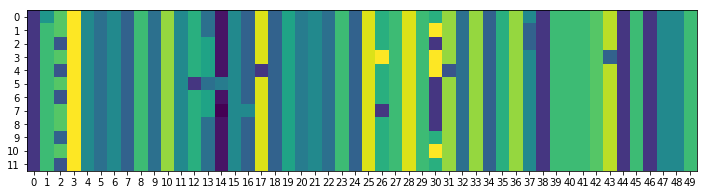

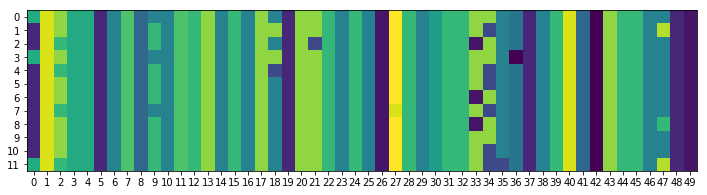

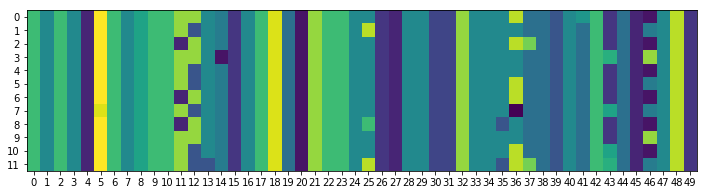

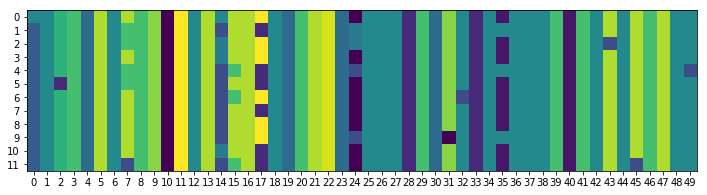

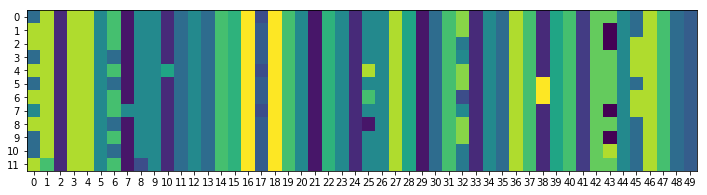

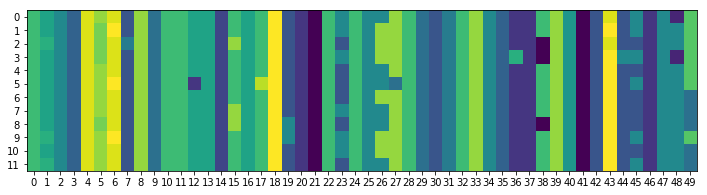

In [198]:
for i in range(6):
    k = np.random.randint(0, 3000)
    l = k + 50
    plt.imshow(chart_argmax[:,k:l])
    plt.yticks(range(12))
    plt.xticks(range(50))
    plt.show()

## ExtraTreesClassifier

In [22]:
ext = ExtraTreesClassifier(n_estimators=50)

In [30]:
params = {'n_estimators' : [100],
          'max_features' : [1000, 5000]}

In [31]:
grid_search = GridSearchCV(ext, params)

In [32]:
grid_search.fit(X_train, Y_raw)

KeyboardInterrupt: 

In [ ]:
sorted(grid_search.cv_results_.keys())

In [ ]:
print(grid_search.cv_results_['mean_test_score'])

In [17]:
cross_val_score(ext, X_train, Y_raw)

array([ 0.5361,  0.5381,  0.5325])